In [1]:
model_size='10000'

In [2]:
import numpy as np
import pickle
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
import os
import sys
import pandas as pd


In [3]:
def handle_helper_functions():
    sys.path.append('/Users/learn/Desktop/Projects/machine-translation/test/helper')                                       
    sys.path.append('/Users/learn/Desktop/Projects/machine-translation/utils')
    sys.path.append('/Users/learn/Desktop/Projects/machine-translation/data')
    sys.path.append('/Users/learn/Desktop/Projects/machine-translation/visualization')

handle_helper_functions()

In [4]:
from performance_metric import create_dataframe_to_score, bleu_score, calculate_ROUGE
from bar_chart import plot_chart_for_all_metrics, plotBarChart

In [5]:
def load_models_and_parameters(model_size):

    path=model_size+'/'

    from tensorflow import keras
    model = keras.models.load_model(path+'lstm_model')
    with open(path+ "src_parameters.pickle", 'rb') as handle:
        src_parameters = pickle.load(handle)

    with open(path+ "src_tokenizer.pickle", 'rb') as handle:
        src_tokenizer = pickle.load(handle)

    with open(path+ "target_parameters.pickle", 'rb') as handle:
        target_parameters = pickle.load(handle)

    with open(path+ "target_tokenizer.pickle", 'rb') as handle:
        target_tokenizer = pickle.load(handle)
    return model, src_tokenizer, target_tokenizer, src_parameters, target_parameters

model_path= '../../model/lstm/'+model_size
model, src_tokenizer, target_tokenizer, src_parameters, target_parameters= load_models_and_parameters(model_path)

2023-01-22 22:37:57.618904: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-01-22 22:37:57.920567: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-01-22 22:37:57.927800: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-01-22 22:37:57.980363: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-01-22 22:37:58.369675: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_sh

In [6]:

src_length=src_parameters["src_length"]
src_vocab_size=src_parameters["src_vocab_size"]

target_length=target_parameters["target_length"]
target_vocab_size=target_parameters["target_vocab_size"]

print(src_length, target_length, src_vocab_size, target_vocab_size)




15 15 2384 1911


In [7]:
from iit_dataset import createDataset

Using custom data configuration cfilt--iitb-english-hindi-911387c6837f8b91
Reusing dataset parquet (/Users/learn/.cache/huggingface/datasets/parquet/cfilt--iitb-english-hindi-911387c6837f8b91/0.0.0/1638526fd0e8d960534e2155dc54fdff8dce73851f21f031d2fb9c2cf757c121)


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
data_size=1000

pool_oftexts, pairs =createDataset(data_size=data_size, type="test")
dataset= pool_oftexts
dataset = dataset.values
test=dataset

In [9]:
source_str, target_str = "Hindi", "English"


In [10]:
def encode_sequences(tokenizer, length, lines):
    # encode and pad sequences
    X = tokenizer.texts_to_sequences(lines) # integer encode sequences
    X = pad_sequences(X, maxlen=length, padding='post') # pad sequences with 0 values
    return X
 
def encode_output(sequences, vocab_size):
    # one hot encode target sequence
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = np.array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

In [11]:
def word_for_id(integer, tokenizer):
    # map an integer to a word
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
def predict_seq(model, tokenizer, source):
    # generate target from a source sequence
    prediction = model.predict(source, verbose=0)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

def compare_prediction(model, tar_tokenizer, sources, raw_dataset, limit=20):
    # evaluate a model
    actual, predicted = [], []
    src = f'{source_str.upper()} (SOURCE)'
    tgt = f'{target_str.upper()} (TARGET)'
    pred = f'AUTOMATIC TRANSLATION IN {target_str.upper()}'
    print(f'{src:30} {tgt:25} {pred}\n')
    
    for i, source in enumerate(sources): # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_src,raw_target = raw_dataset[i]
        print(f' {i+1}. {raw_src:30} || {raw_target:25} || {translation}')
        if i >= limit: # Display some of the result
            break
 


In [12]:
# Prepare test data
idx_src=0
idx_tar=1
testX = encode_sequences(src_tokenizer, src_length, test[:, idx_src])
testY = encode_sequences(target_tokenizer, target_length, test[:, idx_tar])
testY = encode_output(testY, target_vocab_size)

In [13]:
print('\n\n### Result on the Test Set ###')
compare_prediction(model, target_tokenizer, testX, test)



### Result on the Test Set ###
HINDI (SOURCE)                 ENGLISH (TARGET)          AUTOMATIC TRANSLATION IN ENGLISH



2023-01-22 22:38:06.676640: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 1. आपकी कार में ब्लैक बॉक्स       || a black box in your car   || make stack
 2. जबकि अमेरिका के सड़क योजनाकार ध्वस्त होते हुए हाईवे सिस्टम को सुधारने के लिए धन की कमी से जूझ रहे हैं वहीं बहुतसे लोग इसका समाधान छोटे से ब्लैक बॉक्स में देख रहे हैं जो आपकी कार के डैशबोर्ड पर सफ़ाई से फिट हो जाता है। || as americas road planners struggle to find the cash to mend a crumbling highway system many are beginning to see a solution in a little black box that fits neatly by the dashboard of your car || the are for the
 3. यह डिवाइस जो मोटरचालक द्वारा वाहन चलाए गए प्रत्येक मील को ट्रैक करती है तथा उस सूचना को अधिकारियों को संचारित करती है आजकल अमेरिका की प्रमुख सड़कों का वित्तपोषण करने के लिए पुराने हो चुके सिस्टम का जीर्णोद्धार करने के लिए वाशिंगटन और राज्य नियोजन कार्यालय के लिए एक विवादास्पद प्रयास का मुद्दा बन चुका है। || the devices which track every mile a motorist drives and transmit that information to bureaucrats are at the center of a controversial attempt in washington and state planni

### Statistics for Single Model

In [14]:
actual, predicted, actual_rouge, average_cosine =create_dataframe_to_score(model, target_tokenizer, testX, test)
bleu_test = bleu_score(actual, predicted)
rouge_test = calculate_ROUGE(actual=actual_rouge, predicted=predicted)

keys=["Dataset Size", *rouge_test.keys(), "cosine_similarity", *bleu_test.keys()]

values=[model_size,  *rouge_test.values(), average_cosine, *bleu_test.values() ]

table =pd.DataFrame(columns=keys, data=[values])

/Users/learn/Desktop/Projects/machine-translation/.env/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/learn/Desktop/Projects/machine-translation/.env/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


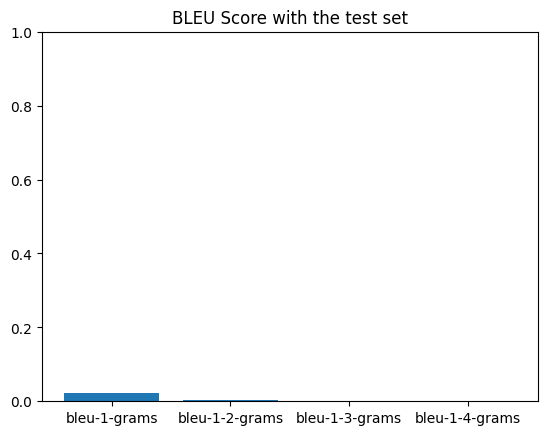

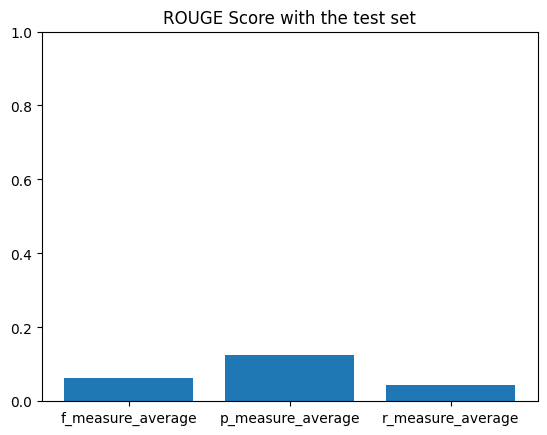

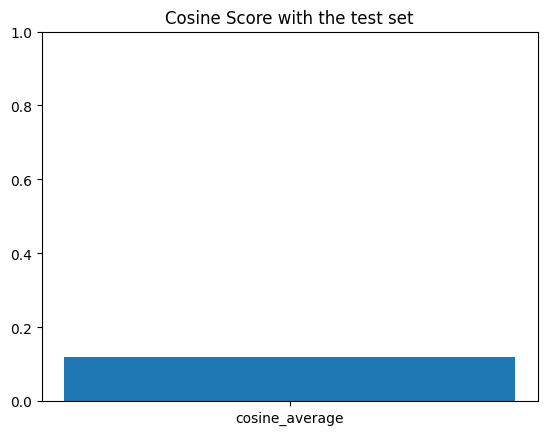

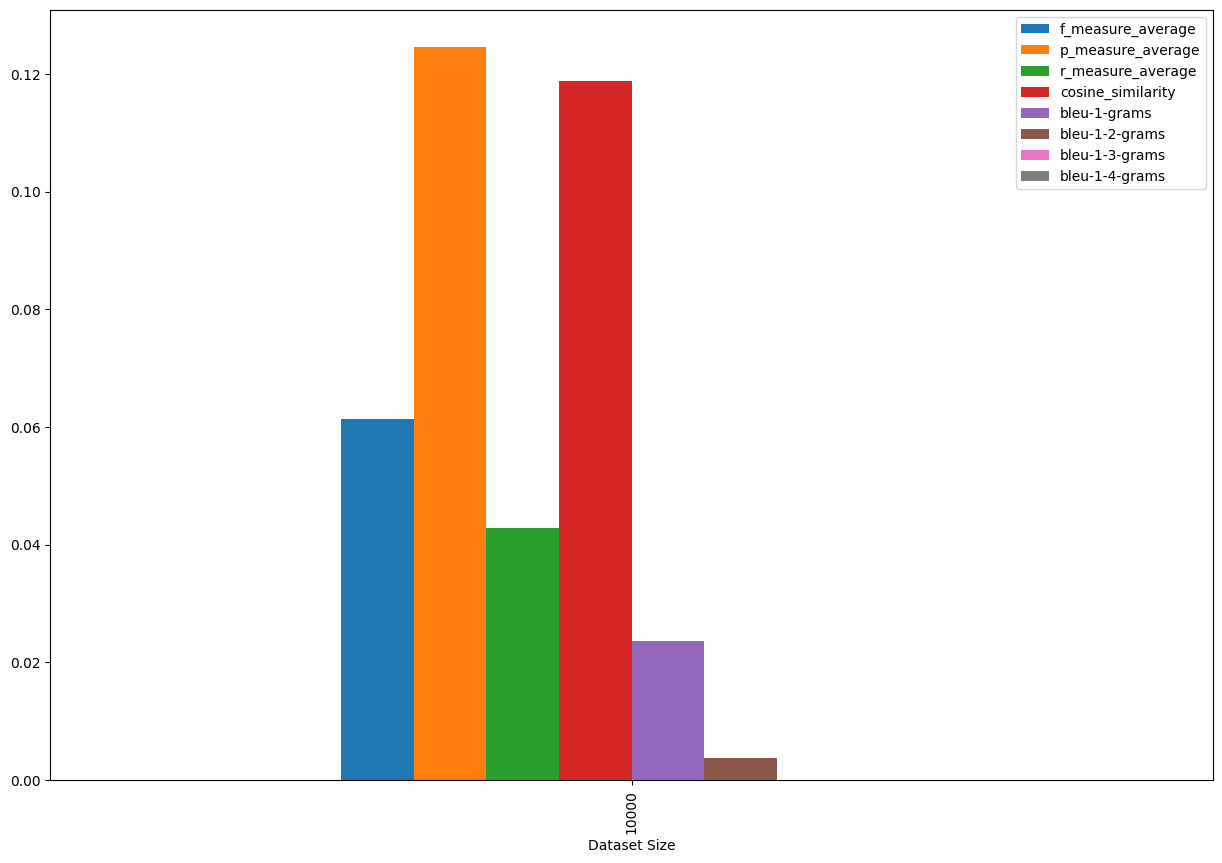

In [15]:

plotBarChart(x = bleu_test.keys(), height = bleu_test.values(), title= "BLEU Score with the test set")

plotBarChart(x = rouge_test.keys(), height = rouge_test.values(), title= "ROUGE Score with the test set")

plotBarChart(x = "cosine_average", height = average_cosine, title= "Cosine Score with the test set")


plot_chart_for_all_metrics(table=table)


### Transliterate English to Hindi

In [16]:
! pip install google-transliteration-api
from google.transliteration import transliterate_word


In [17]:

transliterate_eng_hindi = transliterate_word('yah hamaare desh ke lie vaastav mein anivaary vastu hai.', lang_code='hi', max_suggestions=1)
print(transliterate_eng_hindi)

['यह हमारे देश के लिए वास्तव में अनिवार्य वस्तु है.']


In [18]:
encoded_hindi = encode_sequences(src_tokenizer, src_length, transliterate_eng_hindi)
encoded_hindi
actual= [[transliterate_eng_hindi[0], 'It is really essential item for our country.']]

In [19]:
compare_prediction(model, target_tokenizer, encoded_hindi, actual)

HINDI (SOURCE)                 ENGLISH (TARGET)          AUTOMATIC TRANSLATION IN ENGLISH

 1. यह हमारे देश के लिए वास्तव में अनिवार्य वस्तु है. || It is really essential item for our country. || this of available for this
